# Infering Nutritional Information from Semantic Image Segmentation

This notebook contains the implementation of the semantic image segmentation model that forms the backbone of Grocerly's nutritient scoring and gamification functionality.

We use Google's `mobile-food-segmenter-v1` model for image segmentation and classification. This model classifies each image segment into one of 26 food groups (e.g. grains or leafy greens). It is trained on the Nutrition5k dataset to use RGB data. For each food group, a number of examples for speific foods are provided in `example_foods.csv`. These example foods are then used to query OpenFoodFacts API (`https://world.openfoodfacts.org/`) for nutritional information and Nova scores.

Portion estimation is based on a list of standard serving sizes for the food groups. These serving sizes are used to scale the nutritional information obtained from OpenFoodFacts in order to gauge the overall calories and macronutrients in a meal.

Finally, detected food groups and their respective Nova scores are used to make recommendations for healthier food swaps.

***NOTE:*** **The final code block contains functionality for you to run our model and predictions only on your own submitted image if you wish.**

## Setup and Structure
This notebook provides an inference framework on the segmentation/classification model. It can be used with the Nutrition5k test dataset, or with some realistic data collected by our team members (and team members' friends/families) throughout the day, which can be downloaded here: https://drive.google.com/drive/folders/1EX0ZKHau61OdcsPHKiuA0JBIdK9nmoCO?usp=sharing

*   `data_real` should hold the image test data




Download model and label maps:

In [248]:
!pip install openfoodfacts
!gdown --id '1BZbkFjxPduKQuajk2GvCn9REM_gTximA'
!gdown --id '1GbHq_T3DFItDk30F7hJNORQdHncrTFBZ'
!gdown --id '1U9fDxFk3ScdTEWFo7cabQftSAmjBr8vk'

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1BZbkFjxPduKQuajk2GvCn9REM_gTximA
To: /content/seefood_mobile_food_segmenter_V1_labelmap.csv
100% 703/703 [00:00<00:00, 1.99MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1GbHq_T3DFItDk30F7hJNORQdHncrTFBZ
To: /content/example_foods.csv
100% 555/555 [00:00<00:00, 1.73MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
F

In [ ]:
# imports

# Standard library imports
import ast
import csv
import json
import os
import sys
import tarfile

# Related third-party imports
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from scipy import stats
from tqdm import tqdm
import torch
from transformers import DPTForDepthEstimation, DPTFeatureExtractor

# Local application/library specific imports
import openfoodfacts

## Constants

To avoid unnecessary output, a `DEBUG`- flag is added. If you want more information about underlying decisions, it can be changed to `True` in order to get more output.

***NOTE:*** The Openfoodfacts-API requires a user agent. If the API calls time out, it helps to change this agent to any other name.

In [ ]:
DEBUG = False
api = openfoodfacts.API(user_agent="someuser/something")
model_filename = '/content/mobile-food-segmenter.tar.gz'
extracted_folder_path = 'extracted_model'

The following function uses the Google model in order to compute a semantic segmentation mask over an image provided to it as a method argument:

In [ ]:
def computeSegmentationMask(filename):

    if not os.path.exists(extracted_folder_path):
        with tarfile.open(model_filename, 'r:gz') as tar:
            tar.extractall(path=extracted_folder_path)
        if DEBUG:
          print("Model extracted")

    # Load the image
    image_path = filename
    image = tf.image.decode_image(tf.io.read_file(image_path))
    image = tf.image.resize(image, [513, 513])
    image = image / 255.0  # Normalize to [0, 1]

    if DEBUG:
      print("Image loaded")

    # Check if the image is 3-channel RGB
    if image.shape[-1] != 3:
        print("Make sure your image is RGB.")

    # Expand dimensions for batch
    image_batch = tf.expand_dims(image, 0)

    # Load the local model with specified output keys
    m = hub.KerasLayer(extracted_folder_path, signature_outputs_as_dict=True)
    if DEBUG:
      print("Model loaded")

    # Use the model
    results = m(image_batch)

    if DEBUG:
      print("Model used")

    segmentation_probs = results['food_group_segmenter:semantic_probabilities'][0]
    segmentation_mask = results['food_group_segmenter:semantic_predictions'][0]

    return segmentation_probs, segmentation_mask

Next, we use a CSV reader to parse information about food groups, standard food group serving sizes, and example foods for each group.

In [ ]:
def read_csv_to_dict(file_path, example_path):
    data_dict = {}
    serving_sizes = {}
    example_foods = {}

    with open(file_path, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)  # Skip the header row
        for row in csvreader:
            key, label, serving_size = row
            data_dict[int(key)] = label.split('|')
            serving_sizes[int(key)] = serving_size

    with open(example_path, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)  # Skip the header row
        for row in csvreader:
            key, ex1, ex2, ex3 = row
            examples = [ex1, ex2, ex3]
            example_foods[int(key)] = examples

    return data_dict, serving_sizes, example_foods

Since the model tends to detect small irregularities in images and assign them to a food class, while Grocerly is focused on the overall composition of a meal, we only regard the 3 largest segmentation areas in an image (so long as they are not labelled as "background").

In [ ]:
def get_top_k_labels(segmentation_mask, k=3):
    # Flatten the segmentation mask
    flat_mask = segmentation_mask.flatten()
    exclude_labels = [0] #, 23, 24, 25] # exclude background, food containers, cutlery

    # Count the occurrence of each unique label in the mask
    labels, counts = np.unique(flat_mask, return_counts=True)

    # Apply exclusion mask to remove unwanted labels
    exclusion_mask = np.isin(labels, exclude_labels, invert=True)
    labels = labels[exclusion_mask]
    counts = counts[exclusion_mask]

    # Sort the counts in descending order to find the top labels
    sorted_indices = np.argsort(-counts)
    top_labels = labels[sorted_indices[:k]]
    top_counts = counts[sorted_indices[:k]]

    # Calculate the ratio of each label's count to the total count of the top labels
    total_top_counts = np.sum(top_counts)
    ratios = top_counts / total_top_counts

    if DEBUG:
      print(f"Counting ratios: {ratios}")
    return top_labels, ratios

Visualization for original images and segmentation masks:

In [ ]:
from scipy.ndimage import center_of_mass
import matplotlib.image as mpimg

def visualize_segmentation_mask(segmentation_mask, filename):
    k = 3

    # Load and preprocess the image as per the provided method
    image_path = filename
    image = tf.image.decode_image(tf.io.read_file(image_path))
    image = tf.image.resize(image, [513, 513])
    image = image / 255.0  # Normalize to [0, 1]

    if DEBUG:
      print("Image loaded")

    # Assuming segmentation_mask is a TensorFlow tensor, convert it to numpy
    if isinstance(segmentation_mask, tf.Tensor):
        segmentation_mask = segmentation_mask.numpy()

    # Get the top k labels from the segmentation mask
    top_k_labels = get_top_k_labels(segmentation_mask, k)

    # Mask to only show top k labels in the segmentation
    top_k_mask = np.isin(segmentation_mask, top_k_labels)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Adjusted for side-by-side view

    # Display the original image on the left
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Display the segmented image on the right, filtered by top k labels
    ax[1].imshow(image, alpha=0.1)
    ax[1].imshow(top_k_mask * segmentation_mask, cmap='jet', alpha=0.8)
    ax[1].set_title(f'Top {k} Food Groups')
    ax[1].axis('off')

    unique_segments = np.unique(segmentation_mask[top_k_mask])
    for segment in unique_segments:
        # Find the center of mass for each top k segment
        centroid = center_of_mass(segmentation_mask == segment)

        # Display the segment number at its centroid on the segmented image
        ax[1].text(centroid[1], centroid[0], str(segment), color='white', ha='center', va='center')

    plt.show()

Next, we query the API for the foods that are detected in an image. This returns nutritional information per 100g. We scale these values, based on the standard serving sizes defined in the label map.

In [ ]:
def fetch_data_from_api(query):

    if DEBUG:
      print(f"Query term: {query}")
    query_data = api.product.text_search(query).get("products")

    calories, carbs, fat, protein, sugar, salt = extract_nutrient_data(query_data)
    return calories, carbs, fat, protein, sugar, salt

    # print(f"API return: {json_data}")
    # if int(json_data["nutrients"]["nova-group"]) != 1:
    #     recommend_healthy_suggestions(json_data, int(json_data["nutrients"]["nova-group"]), 3)


def extract_nutrient_data(api_obj):
    allergens = api_obj[0].get("allergens")
    nutrients = api_obj[0].get("nutriments")

    json_data = {}
    try:
      json_data = {
          "name": api_obj[0].get("abbreviated_product_name"),
          "categories": [],
          "nutrients": {
              "nova-group": nutrients["nova-group"],
              "proteins_100g": nutrients["proteins_100g"],
              "saturated-fat_100g": nutrients["saturated-fat_100g"],
              "fat_100g": nutrients["fat_100g"],
              "energy_100g": nutrients["energy_100g"],
              "carbohydrates_100g": nutrients["carbohydrates_100g"]
          },
          "allergens": allergens
      }
    except Exception as e:
      print(f"Caught error: {e}")
      json_data["nutrients"]["nova-group"] = 0
      json_data["saturated-fat_100g"] = 0



    for i in range(3):
        if i < len(api_obj[0].get("categories_hierarchy")):
            json_data["categories"].append(api_obj[0].get("categories_hierarchy")[i])

    optional_nutrients = ["salt_100g", "sugars_100g", "ph_100g"]
    for nutrient in optional_nutrients:
        if nutrient in nutrients:
            json_data["nutrients"][nutrient] = nutrients[nutrient]

    json_string = json.dumps(json_data)

    # print(f"API Response: {json_string}")

    nutrients = json_data.get('nutrients', {})
    energy = nutrients.get('energy_100g', 0) # kJ
    carbs = nutrients.get('carbohydrates_100g', 0)
    fat = nutrients.get('fat_100g', 0)
    protein = nutrients.get('proteins_100g', 0)
    sugar = nutrients.get('sugars_100g', 0)
    salt = nutrients.get('salt_100g', 0)

    # print(calories, carbs, fat, protein)
    calories = energy / 4.184
    return calories, carbs, fat, protein, sugar, salt


## Main Function
Putting it all together: Finally we iterate over all images in the provided dataset and make predictions on the food groups present, as well as the nutritional values.

coffee_1.jpeg


Computing Nutritional Facts: 100%|██████████| 100/100 [00:06<00:00, 15.37it/s]

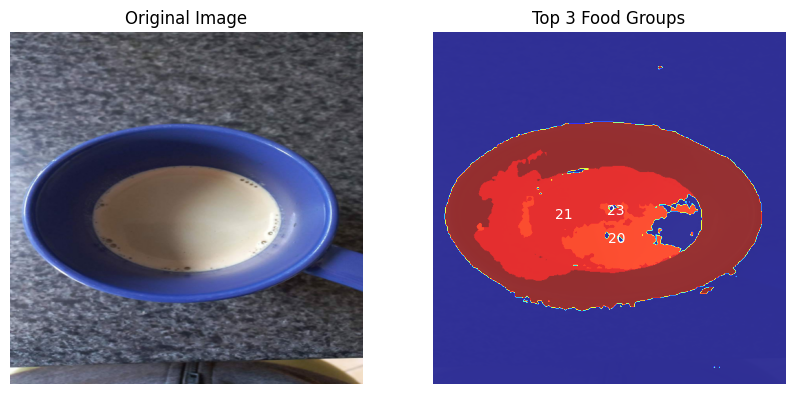

Computing Nutritional Facts: 100%|██████████| 100/100 [00:11<00:00,  8.54it/s]



      Nutritional Information for the Meal:
      ----------------------------------
      Calories:      169.86 kcal
      Carbohydrates: 28.61 g
      Protein:       1.66 g
      Fat:           4.47 g
      Sugar:         18.88 g
      Salt:          0.19 g
      
apple_banana_drink.jpeg


Computing Nutritional Facts: 100%|██████████| 100/100 [00:07<00:00, 13.56it/s]

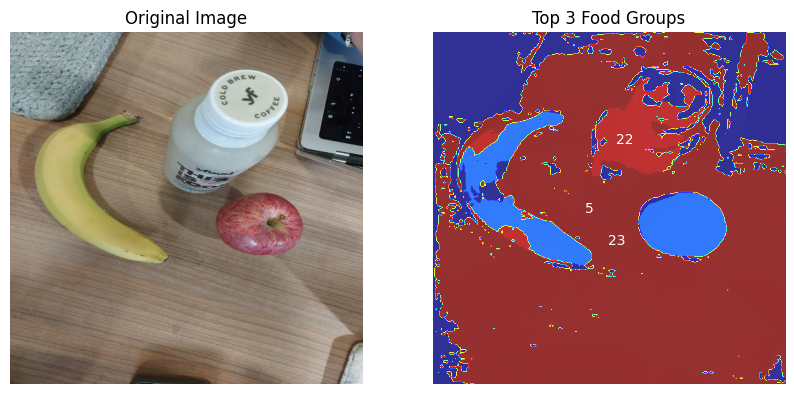

Computing Nutritional Facts: 100%|██████████| 100/100 [00:11<00:00,  8.56it/s]



      Nutritional Information for the Meal:
      ----------------------------------
      Calories:      420.44 kcal
      Carbohydrates: 53.90 g
      Protein:       8.41 g
      Fat:           17.34 g
      Sugar:         12.79 g
      Salt:          0.66 g
      
pasta_brokkoli_and_cherries.jpeg


Computing Nutritional Facts: 100%|██████████| 100/100 [00:02<00:00, 37.89it/s]

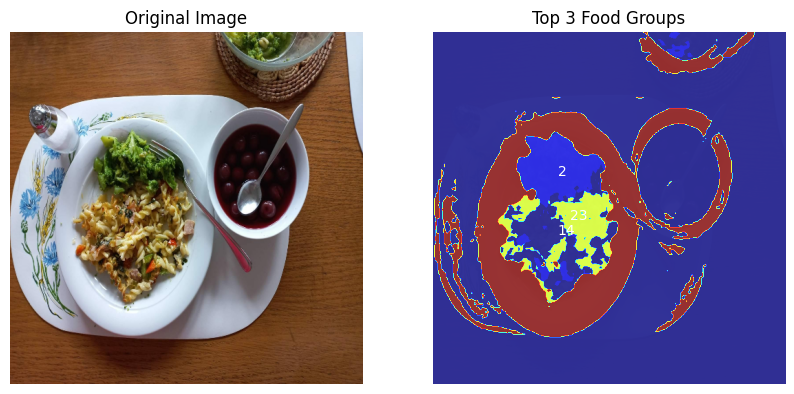

Computing Nutritional Facts: 100%|██████████| 100/100 [00:06<00:00, 14.51it/s]



      Nutritional Information for the Meal:
      ----------------------------------
      Calories:      309.11 kcal
      Carbohydrates: 60.16 g
      Protein:       1.04 g
      Fat:           6.82 g
      Sugar:         0.99 g
      Salt:          0.36 g
      
cookie.jpeg


Computing Nutritional Facts: 100%|██████████| 100/100 [00:02<00:00, 35.52it/s]

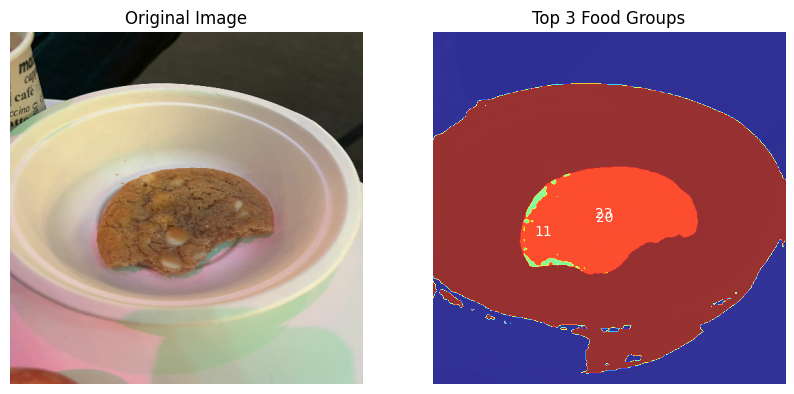

Computing Nutritional Facts: 100%|██████████| 100/100 [00:07<00:00, 14.03it/s]



      Nutritional Information for the Meal:
      ----------------------------------
      Calories:      463.49 kcal
      Carbohydrates: 68.38 g
      Protein:       6.41 g
      Fat:           16.63 g
      Sugar:         31.03 g
      Salt:          0.51 g
      
coffee_2.jpeg


Computing Nutritional Facts: 100%|██████████| 100/100 [00:03<00:00, 29.15it/s]

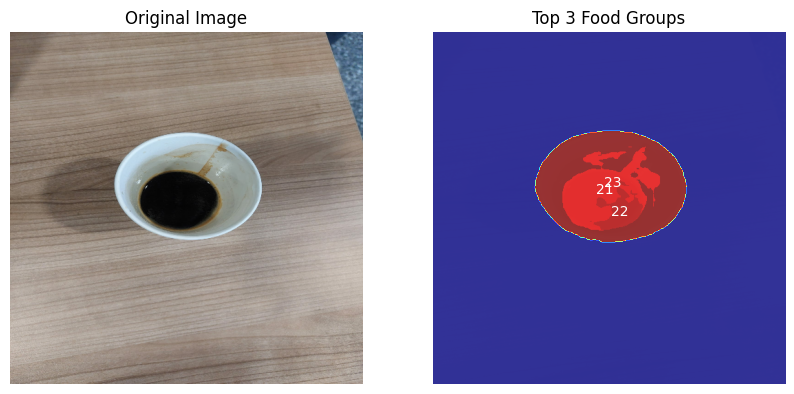

Computing Nutritional Facts: 100%|██████████| 100/100 [00:07<00:00, 13.37it/s]



      Nutritional Information for the Meal:
      ----------------------------------
      Calories:      141.52 kcal
      Carbohydrates: 24.52 g
      Protein:       3.23 g
      Fat:           2.60 g
      Sugar:         18.50 g
      Salt:          0.49 g
      
tea.jpeg


Computing Nutritional Facts: 100%|██████████| 100/100 [00:02<00:00, 36.29it/s]

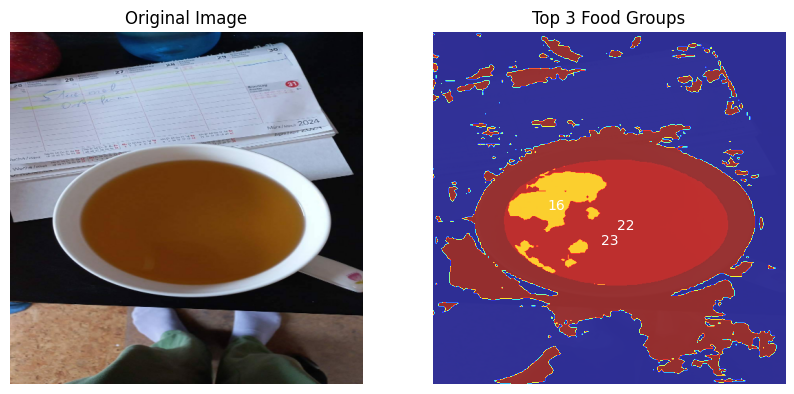

Computing Nutritional Facts: 100%|██████████| 100/100 [00:06<00:00, 16.08it/s]



      Nutritional Information for the Meal:
      ----------------------------------
      Calories:      21.34 kcal
      Carbohydrates: 2.12 g
      Protein:       2.10 g
      Fat:           0.30 g
      Sugar:         0.25 g
      Salt:          0.90 g
      
apple_2.jpeg


Computing Nutritional Facts: 100%|██████████| 100/100 [00:03<00:00, 29.49it/s]

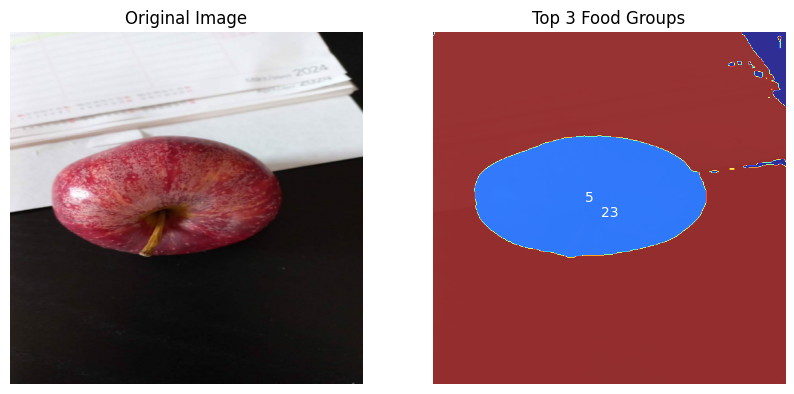

Computing Nutritional Facts: 100%|██████████| 100/100 [00:06<00:00, 15.94it/s]



      Nutritional Information for the Meal:
      ----------------------------------
      Calories:      82.10 kcal
      Carbohydrates: 18.00 g
      Protein:       1.35 g
      Fat:           0.00 g
      Sugar:         15.00 g
      Salt:          0.00 g
      
apple_1.jpeg


Computing Nutritional Facts: 100%|██████████| 100/100 [00:02<00:00, 34.09it/s]

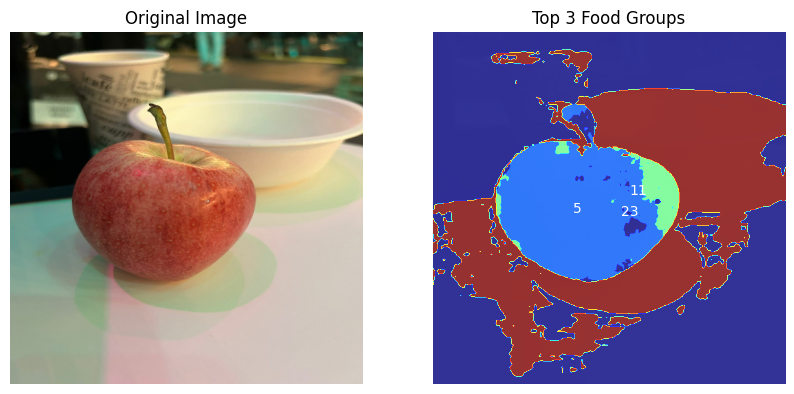

Computing Nutritional Facts: 100%|██████████| 100/100 [00:06<00:00, 14.85it/s]



      Nutritional Information for the Meal:
      ----------------------------------
      Calories:      645.15 kcal
      Carbohydrates: 84.17 g
      Protein:       13.08 g
      Fat:           25.93 g
      Sugar:         18.91 g
      Salt:          0.61 g
      
banana_and_drink.jpeg


Computing Nutritional Facts: 100%|██████████| 100/100 [00:03<00:00, 29.76it/s]

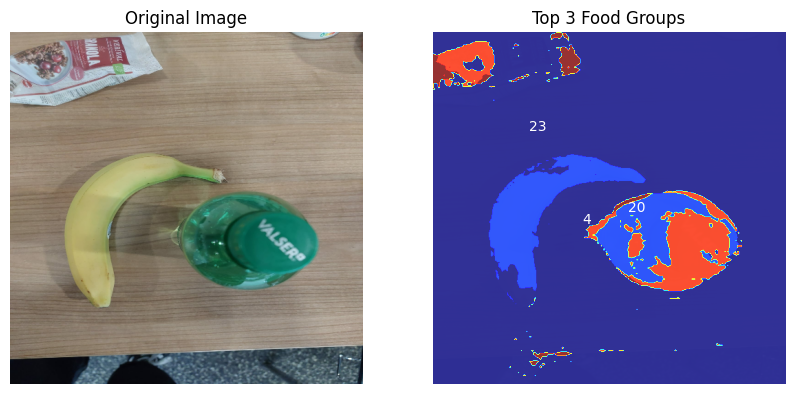

Computing Nutritional Facts: 100%|██████████| 100/100 [00:08<00:00, 11.99it/s]



      Nutritional Information for the Meal:
      ----------------------------------
      Calories:      214.33 kcal
      Carbohydrates: 29.69 g
      Protein:       3.12 g
      Fat:           8.41 g
      Sugar:         16.08 g
      Salt:          0.99 g
      
yoghurt.jpeg


Computing Nutritional Facts: 100%|██████████| 100/100 [00:02<00:00, 34.92it/s]

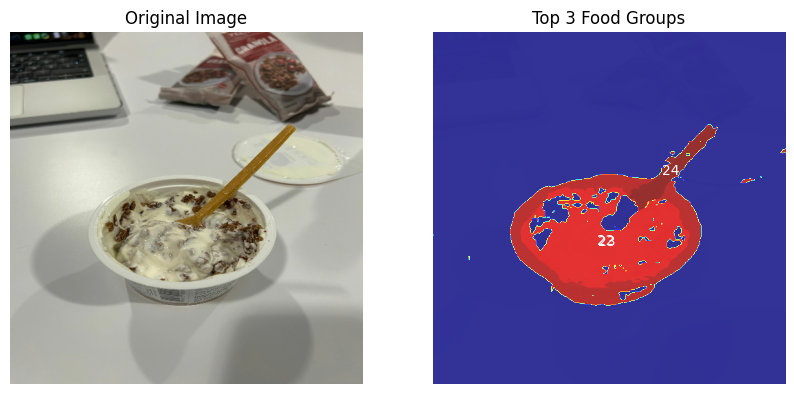

Computing Nutritional Facts: 100%|██████████| 100/100 [00:05<00:00, 19.35it/s]


      Nutritional Information for the Meal:
      ----------------------------------
      Calories:      26.40 kcal
      Carbohydrates: 0.03 g
      Protein:       0.03 g
      Fat:           2.95 g
      Sugar:         0.03 g
      Salt:          0.06 g
      

      Nutritional Information for the Meal:
      ----------------------------------
      Calories:      26.40 kcal
      Carbohydrates: 0.03 g
      Protein:       0.03 g
      Fat:           2.95 g
      Sugar:         0.03 g
      Salt:          0.06 g
      

      Nutritional Information for the Meal:
      ----------------------------------
      Calories:      26.40 kcal
      Carbohydrates: 0.03 g
      Protein:       0.03 g
      Fat:           2.95 g
      Sugar:         0.03 g
      Salt:          0.06 g
      


In [ ]:
directory_path = '/content/data_real/'

label_dict, serving_sizes, example_foods = read_csv_to_dict('/content/seefood_mobile_food_segmenter_V1_labelmap.csv', '/content/example_foods.csv')


for filename in os.listdir(directory_path):
    if os.path.isfile(os.path.join(directory_path, filename)):
      print(filename)

      total_cals = []
      total_protein = []
      total_carbs = []
      total_fat = []
      total_salt = []
      total_sugar = []
      actual_ratios = []

      with tqdm(total=100, desc="Computing Nutritional Facts") as pbar:
        class_probabilities, mask = computeSegmentationMask(os.path.join(directory_path, filename))
        pbar.update(100)

        visualize_segmentation_mask(mask, os.path.join(directory_path, filename))
        top_labels, ratios = get_top_k_labels(mask.numpy(), k=3)

        if DEBUG:
          print("Top labels:")

        for i in range(0, len(top_labels)):
            top_label  = top_labels[i]
            ratio = ratios[i]
            label_value = label_dict.get(top_label, "Label not found")  # Retrieve the value from label_dict or display a message if not found


            mass_scale = int(serving_sizes[top_label]) / 100

            if DEBUG:
              print(f"{label_value}")

            if top_label not in [23, 24, 25]:

              # API-Call
              actual_ratios.append(ratio)
              calories, carbs, fat, protein, sugar, salt = fetch_data_from_api(np.random.choice(example_foods[top_label], 1))
              total_cals.append(calories*mass_scale)
              total_carbs.append(carbs*mass_scale)
              total_fat.append(fat*mass_scale)
              total_protein.append(protein*mass_scale)
              total_sugar.append(sugar*mass_scale)
              total_salt.append(salt*mass_scale)

    if not np.isclose(np.sum(actual_ratios), 1):
        # Scale each ratio by dividing by the total sum to make the sum of ratios equal to 1
        ratios = [ratio / np.sum(actual_ratios) for ratio in actual_ratios]

    if DEBUG:
      print(f"Ratios: {ratios}")

    # Compute weighted averages
    weighted_avg_cals = np.dot(ratios, total_cals)
    weighted_avg_carbs = np.dot(ratios, total_carbs)
    weighted_avg_fat = np.dot(ratios, total_fat)
    weighted_avg_protein = np.dot(ratios, total_protein)
    weighted_avg_sugar = np.dot(ratios, total_sugar)
    weighted_avg_salt = np.dot(ratios, total_salt)

    print(f"""
      Nutritional Information for the Meal:
      ----------------------------------
      Calories:      {weighted_avg_cals:.2f} kcal
      Carbohydrates: {weighted_avg_carbs:.2f} g
      Protein:       {weighted_avg_protein:.2f} g
      Fat:           {weighted_avg_fat:.2f} g
      Sugar:         {weighted_avg_sugar:.2f} g
      Salt:          {weighted_avg_salt:.2f} g
      """)

